In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
import xgboost as xgb
from xgboost import plot_importance
import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading the dataset
print("Start Data Processing")
df1 = pd.read_csv('Datasets/Monday-WorkingHours.pcap_ISCX.csv')
df2 = pd.read_csv('Datasets/Tuesday-WorkingHours.pcap_ISCX.csv')
df3 = pd.read_csv('Datasets/Wednesday-workingHours.pcap_ISCX.csv')
df4 = pd.read_csv('Datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df5 = pd.read_csv('Datasets/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
df6 = pd.read_csv('Datasets/Friday-WorkingHours-Morning.pcap_ISCX.csv')
df7 = pd.read_csv('Datasets/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df8 = pd.read_csv('Datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df = pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7
df = pd.concat([df,df8])
del df8

df.columns = df.columns.str.strip()
nRow, nCol = df.shape
print(f'The table has {nRow} rows and {nCol} columns')

Start Data Processing
The table has 2830743 rows and 79 columns


In [5]:
# Renaming the columns by removing leading/trailing whitespace
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True) 

In [7]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  Flow I

In [11]:
# Optimizing memory usage for the dataset 'df'
old_memory_usage = df.memory_usage().sum() / 1024 ** 2
print(f'Initial memory usage: {old_memory_usage:.2f} MB')

# Loop through each column for downcasting
for col in df.columns:
    col_type = df[col].dtype
    if col_type != object:  # Skip object/string columns
        c_min = df[col].min()
        c_max = df[col].max()
        
        # Downcasting float64 to float32
        if str(col_type).find('float') >= 0 and c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
        
        # Downcasting int64 to int32
        elif str(col_type).find('int') >= 0 and c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            df[col] = df[col].astype(np.int32)

new_memory_usage = df.memory_usage().sum() / 1024 ** 2
print(f'Final memory usage: {new_memory_usage:.2f} MB')


Initial memory usage: 1727.75 MB
Final memory usage: 928.66 MB


In [17]:
# Calculating percentage reduction in memory usage
print(f'Reduced memory usage: {1 - (new_memory_usage / old_memory_usage):.2%}')

Reduced memory usage: 46.25%


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2521788 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int32  
 1   Flow Duration                int32  
 2   Total Fwd Packets            int32  
 3   Total Backward Packets       int32  
 4   Total Length of Fwd Packets  int32  
 5   Total Length of Bwd Packets  int32  
 6   Fwd Packet Length Max        int32  
 7   Fwd Packet Length Min        int32  
 8   Fwd Packet Length Mean       float32
 9   Fwd Packet Length Std        float32
 10  Bwd Packet Length Max        int32  
 11  Bwd Packet Length Min        int32  
 12  Bwd Packet Length Mean       float32
 13  Bwd Packet Length Std        float32
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float32
 17  Flow IAT Std                 float32
 18  Flow IAT Max                 int32  
 19  Flow I

### Handeling Dublicate values 

In [13]:
dups = df[df.duplicated()]
print(f'Number of duplicates: {len(dups)}')

Number of duplicates: 308955


In [15]:
df.drop_duplicates(inplace = True)
df.shape

(2521788, 79)

### Handeling Missing Values 

In [16]:
missing_val = df.isna().sum()
print(missing_val.loc[missing_val > 0])

Flow Bytes/s    353
dtype: int64


In [20]:
# Checking for infinity values
numeric_cols = df.select_dtypes(include = np.number).columns
inf_count = np.isinf(df[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Flow Bytes/s      1210
Flow Packets/s    1563
dtype: int64


In [22]:
# Replacing any infinite values (positive or negative) with NaN (not a number)
print(f'Initial missing values: {df.isna().sum().sum()}')

df.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Missing values after processing infinite values: {df.isna().sum().sum()}')

Initial missing values: 353
Missing values after processing infinite values: 3126


In [24]:
missing = df.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s      1563
Flow Packets/s    1563
dtype: int64


In [26]:
# Calculating missing value percentage in the dataset
mis_per = (missing / len(df)) * 100
mis_table = pd.concat([missing, mis_per.round(2)], axis = 1)
mis_table = mis_table.rename(columns = {0 : 'Missing Values', 1 : 'Percentage of Total Values'})

print(mis_table.loc[mis_per > 0])

                Missing Values  Percentage of Total Values
Flow Bytes/s              1563                        0.06
Flow Packets/s            1563                        0.06


In [30]:
med_flow_bytes = df['Flow Bytes/s'].median()
med_flow_packets = df['Flow Packets/s'].median()

print('Median of Flow Bytes/s: ', med_flow_bytes)
print('Median of Flow Packets/s: ', med_flow_packets)

Median of Flow Bytes/s:  3711.813158
Median of Flow Packets/s:  69.63157931


In [32]:
# Filling missing values with median
df['Flow Bytes/s'].fillna(med_flow_bytes, inplace = True)
df['Flow Packets/s'].fillna(med_flow_packets, inplace = True)

In [34]:
print('Number of \'Flow Bytes/s\' missing values:', df['Flow Bytes/s'].isna().sum())
print('Number of \'Flow Packets/s\' missing values:', df['Flow Packets/s'].isna().sum())

Number of 'Flow Bytes/s' missing values: 0
Number of 'Flow Packets/s' missing values: 0


In [36]:
df['Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'Bot', 'PortScan',
       'DDoS'], dtype=object)

In [37]:
df.Label.value_counts()

Label
BENIGN                        2095910
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [38]:
label_mapping = {
    'BENIGN': 'Normal',
    'Bot': 'Botnet',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'DoS Hulk': 'DoS/DDoS',
    'DoS GoldenEye': 'DoS/DDoS',
    'DoS slowloris': 'DoS/DDoS',
    'DoS Slowhttptest': 'DoS/DDoS',
    'DDoS': 'DoS/DDoS',
    'Heartbleed': 'DoS/DDoS',
    'Infiltration': 'Infiltration',
    'PortScan': 'Port Scan',
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack'
}

df['Label'] = df['Label'].map(label_mapping)

In [39]:
#df.to_csv('CICIDS2017_relabled.csv', index=False)
df.Label.value_counts()

Label
Normal          2095910
DoS/DDoS         321775
Port Scan         90819
Brute Force        9152
Web Attack         2143
Botnet             1953
Infiltration         36
Name: count, dtype: int64

## Random sampling

In [48]:
from sklearn.utils import resample

# Remove class 'Infiltration'
df = df[df['Label'] != 'Infiltration']

# Define the sample size range for each class
min_samples = 2000
max_samples = 2200

# Function to randomly sample within the range [min_samples, max_samples]
def random_sample_class(df, label, min_samples, max_samples):
    n_samples = np.random.randint(min_samples, max_samples + 1)
    return resample(df[df['Label'] == label], n_samples=n_samples, random_state=42)

# Define the labels to be resampled
class_labels = ['Normal', 'DoS/DDoS', 'Port Scan', 'Brute Force']

# Apply the random_sample_class function to each class
resampled_dfs = [random_sample_class(df, label, min_samples, max_samples) for label in class_labels]
df_resampled = pd.concat(resampled_dfs + [df[df['Label'] == label] for label in df['Label'].unique() if label not in class_labels])
df = df_resampled

print(df['Label'].value_counts())

Label
Web Attack     2143
Port Scan      2136
Normal         2125
Brute Force    2075
DoS/DDoS       2063
Botnet         1953
Name: count, dtype: int64


## Preprocessing (normalization and padding values)¶

In [49]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

### split train set and test set

In [51]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
y = y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, test_size = 0.3, random_state = 0,stratify = y)

In [52]:
pd.Series(y_train).value_counts()

5    1500
4    1495
3    1487
1    1453
2    1444
0    1367
Name: count, dtype: int64

### Machine learning model training¶
### Training four base learners: decision tree, random forest, extra trees, XGBoost

Accuracy of DT: 0.972259269138437
Precision of DT: 0.9728758550288903
Recall of DT: 0.972259269138437
F1-score of DT: 0.9718871917573125
Training time: 0.1035616397857666 s
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       586
           1       1.00      1.00      1.00       622
           2       0.95      0.99      0.97       619
           3       0.99      0.88      0.93       638
           4       0.99      0.99      0.99       641
           5       0.97      0.98      0.97       643

    accuracy                           0.97      3749
   macro avg       0.97      0.97      0.97      3749
weighted avg       0.97      0.97      0.97      3749



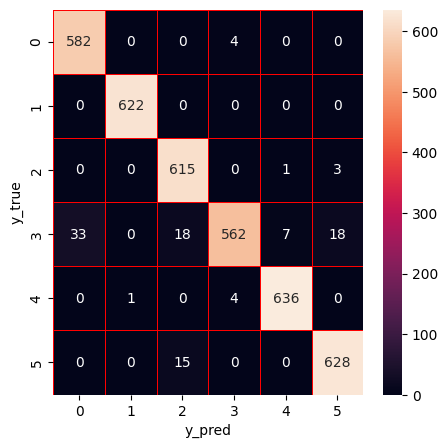

In [53]:
# Decision tree training and prediction
import time

start_time = time.time() 
dt = DecisionTreeClassifier(criterion='gini', splitter= 'best', max_depth=5)
dt.fit(X_train,y_train)
training_time = time.time() - start_time

dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print("Training time:", training_time, "s") 
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [54]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

In [68]:
import joblib

# Assuming 'xgb_model' is your trained XGBoost model
# Save the model to a file
joblib.dump(dt, 'DT_model(A97%).pkl')

print("Model saved successfully.")


Model saved successfully.


## Random Forest

Accuracy of RF: 0.9701253667644705
Precision of RF: 0.9713466447130459
Recall of RF: 0.9701253667644705
F1-score of RF: 0.970321682776748
Training time: 0.855837345123291 s
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       586
           1       1.00      1.00      1.00       622
           2       0.99      0.95      0.97       619
           3       0.89      0.94      0.91       638
           4       0.99      1.00      0.99       641
           5       1.00      0.94      0.97       643

    accuracy                           0.97      3749
   macro avg       0.97      0.97      0.97      3749
weighted avg       0.97      0.97      0.97      3749



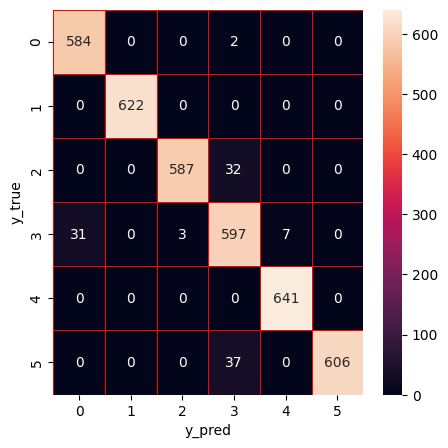

In [64]:
start_time = time.time() 

# Random Forest training and prediction
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5)
rf.fit(X_train,y_train)
training_time = time.time() - start_time

rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print("Training time:", training_time, "s") 
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [56]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

In [65]:
import joblib

# Assuming 'xgb_model' is your trained XGBoost model
# Save the model to a file
joblib.dump(rf, 'rf_model(A96%).pkl')

print("Model saved successfully.")


Model saved successfully.


Accuracy of ET: 0.9391837823419579
Precision of ET: 0.9423005723007398
Recall of ET: 0.9391837823419579
F1-score of ET: 0.9395976676880661
Training time: 0.43736934661865234 s
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       586
           1       0.95      0.96      0.95       622
           2       1.00      0.90      0.95       619
           3       0.82      0.89      0.85       638
           4       0.97      1.00      0.98       641
           5       0.99      0.90      0.94       643

    accuracy                           0.94      3749
   macro avg       0.94      0.94      0.94      3749
weighted avg       0.94      0.94      0.94      3749



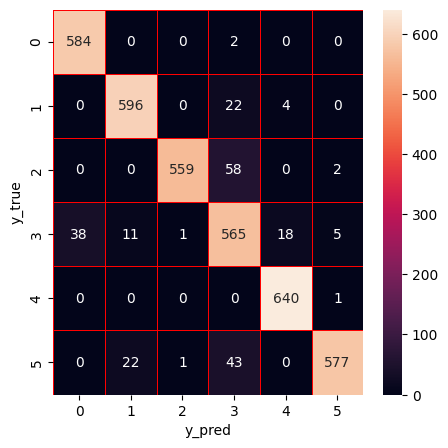

In [57]:
start_time = time.time() 

# Extra trees training and prediction
et = ExtraTreesClassifier(max_depth=5)
et.fit(X_train,y_train)
training_time = time.time() - start_time

et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print("Training time:", training_time, "s") 
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [58]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.9911976527073887
Precision of XGBoost: 0.9912795066037003
Recall of XGBoost: 0.9911976527073887
F1-score of XGBoost: 0.9911317879465951
Training time: 1.249743938446045 s
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       586
           1       1.00      1.00      1.00       622
           2       0.99      1.00      0.99       619
           3       1.00      0.95      0.97       638
           4       0.99      1.00      0.99       641
           5       1.00      1.00      1.00       643

    accuracy                           0.99      3749
   macro avg       0.99      0.99      0.99      3749
weighted avg       0.99      0.99      0.99      3749



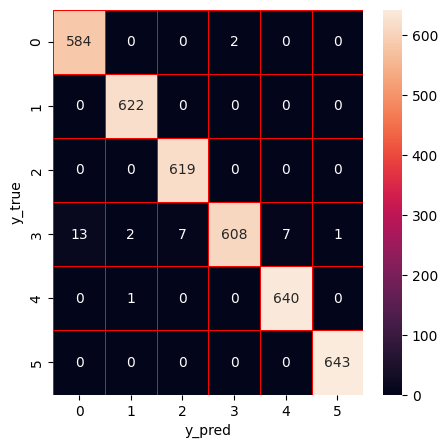

In [59]:
start_time = time.time() 

# XGBoost training and prediction
xg = xgb.XGBClassifier(n_estimators=3)
xg.fit(X_train, y_train)
training_time = time.time() - start_time

xg_score = xg.score(X_test, y_test)
y_predict = xg.predict(X_test)
y_true = y_test
print('Accuracy of XGBoost: ' + str(xg_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print("Training time:", training_time, "s") 

# Print classification report
print(classification_report(y_true, y_predict))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [60]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

In [63]:
import joblib

# Assuming 'xgb_model' is your trained XGBoost model
# Save the model to a file
joblib.dump(xg, 'xgboost_model(99%).pkl')

print("Model saved successfully.")


Model saved successfully.


###Stacking model construction (ensemble for 4 base learners)

In [61]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,0,0,0,3
2,2,2,2,2
3,1,1,1,1
4,0,0,0,0
